In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

Exploring the number of beers per country
Exploring the number of user per country
number of reviews per country

RateBeer exploration

In [2]:
#number of beers per country
breweries = pd.read_csv('../../minimizedData/RB_breweries_small.csv')
print(breweries.head())


   Unnamed: 0     id          location                       name  nbr_beers
0           0   3198             Gabon                    Sobraga          3
1           1  13538  Northern Ireland           Ards Brewing Co.         13
2           2  22304  Northern Ireland  Barrahooley Craft Brewery          4
3           3  22818  Northern Ireland                   Boundary         66
4           4  24297  Northern Ireland            Brewbot Belfast          3


In [3]:

# Group by country (location) and calculate total number of breweries and beers
country_stats = breweries.groupby('location').agg(
    total_breweries=('id', 'nunique'),  # Count of unique breweries per country
    total_beers=('nbr_beers', 'sum')  # Sum of beers per country
).reset_index()

print("Basic stats explorations")
print(country_stats.shape)
#There are 297 different locations where beer originates from

filtered_countries = country_stats[country_stats['total_beers'] >= 4]
print(filtered_countries.shape)
print("there are a total of 267 locations")
print("233 locations have 4 or more beers")
#Do what countries do we automatically remove for our analysis since they don't have enough beers to analyse
#How much do we want to remove

Basic stats explorations
(267, 3)
(233, 3)
there are a total of 267 locations
233 locations have 4 or more beers


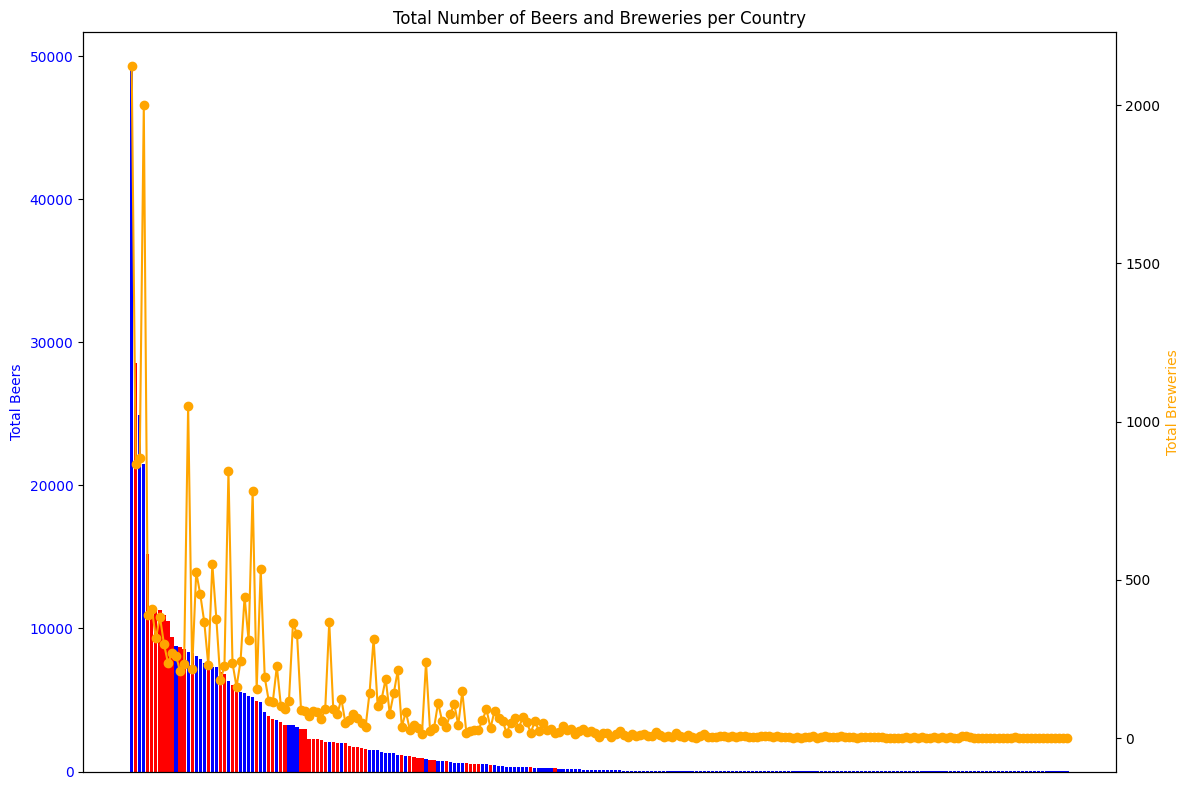

I think looking at the US would be more interesting than anything else


In [4]:
# Plotting the total number of beers and breweries for each country

filtered_countries = filtered_countries.sort_values(by='total_beers', ascending=False)
fig, ax1 = plt.subplots(figsize=(12, 8))
bar_colors = ['red' if country.startswith('United States,') else 'blue' for country in filtered_countries['location']]

# Bar plot for total beers
ax1.bar(filtered_countries['location'], filtered_countries['total_beers'], color=bar_colors, label='Total Beers')
#ax1.set_xlabel('Country')
ax1.set_ylabel('Total Beers', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks([])

# Overlay line plot for total breweries
ax2 = ax1.twinx()
ax2.plot(filtered_countries['location'], filtered_countries['total_breweries'], color='orange', marker='o', label='Total Breweries')
ax2.set_ylabel('Total Breweries', color='orange')
plt.xticks([])

# Adding title and showing legend
plt.title('Total Number of Beers and Breweries per Country')
fig.tight_layout()
plt.show()

print("I think looking at the US would be more interesting than anything else")

In [9]:
filtered_us = filtered_countries[filtered_countries['location'].str.startswith('United States,')]


In [10]:

users = pd.read_csv('../../minimizedData/RB_users_small.csv')
print(users.head())
print("Quick stats on the users")
print("total number of users:", users.shape[0])
#remove users with unknown locations
users = users.dropna(subset=['location'])
print("Number of users with known locations:", users.shape[0])
print("Users originate from: ",users['location'].dropna().nunique() , "different locations")

   Unnamed: 0  nbr_ratings  user_id location
0           0         1890   175852   Poland
1           1           89   442761    Spain
2           2          169   288889   Poland
3           3         3371   250510    Spain
4           4        13043   122778  Germany
Quick stats on the users
total number of users: 70174
Number of users with known locations: 50592
Users originate from:  222 different locations


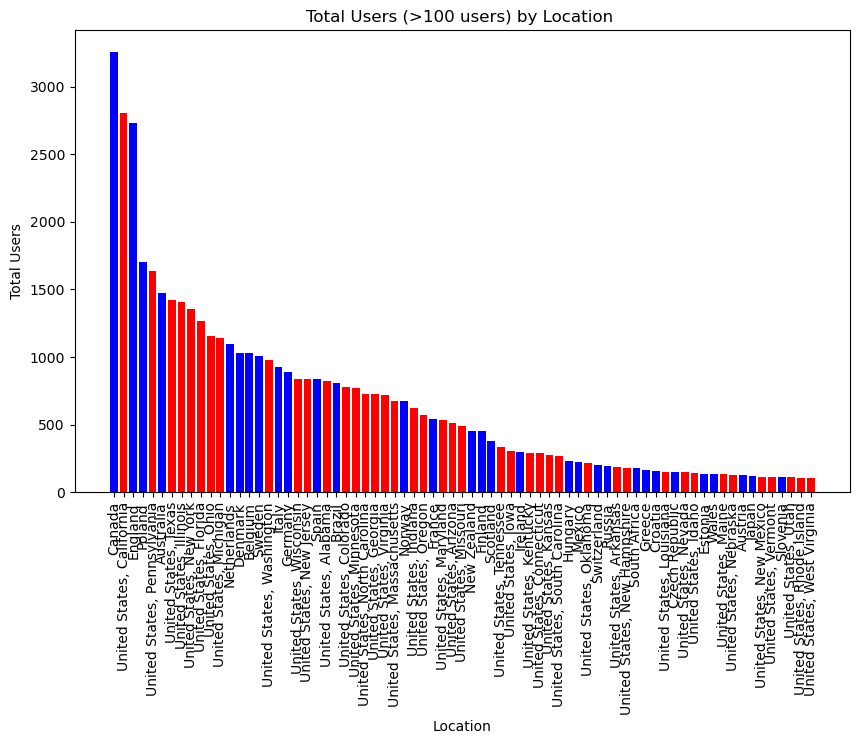

In [11]:

user_counts = users.groupby('location').size().reset_index(name='total_users')
user_counts = user_counts[user_counts['total_users'] >= 100]
user_counts = user_counts.sort_values(by='total_users', ascending=False)
user_counts['color'] = user_counts['location'].apply(lambda x: 'red' if x.startswith('United States,') else 'blue')

plt.figure(figsize=(10, 6))
plt.bar(user_counts['location'], user_counts['total_users'], color=user_counts['color'])
plt.xlabel('Location')
plt.ylabel('Total Users')
plt.title('Total Users (>100 users) by Location ')
plt.xticks(rotation=90)
#plt.xticks([])
plt.show()


In [12]:
us_users = users[users['location'].str.startswith('United States,')]
#Group by location and count the number of users
us_user_counts = us_users.groupby('location').size().reset_index(name='total_users')

#Sort the DataFrame by the total number of users
us_user_counts = us_user_counts.sort_values(by='total_users', ascending=False)



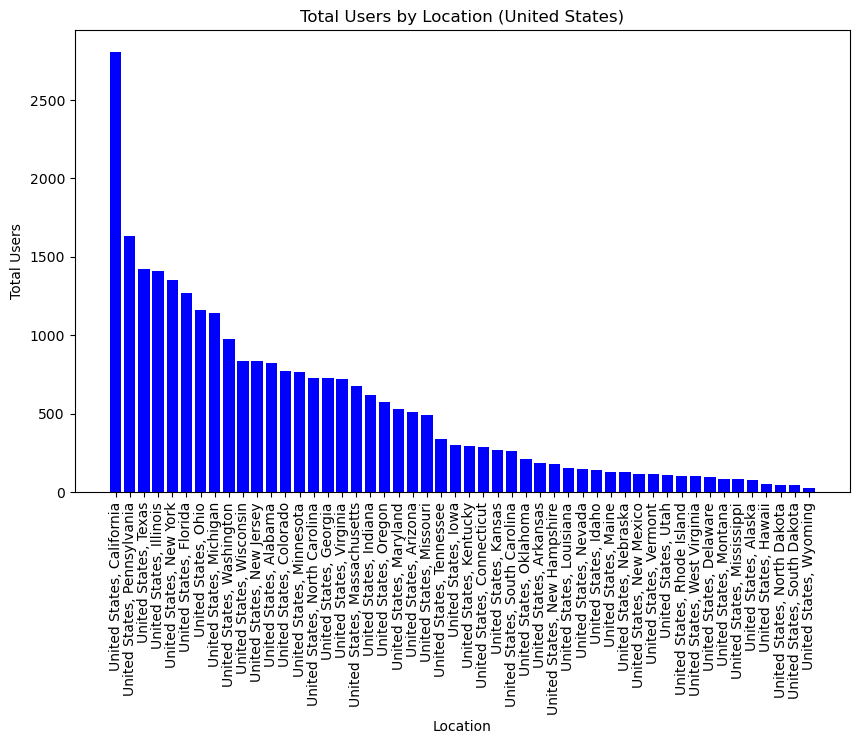

In [13]:
#Plotting US users distribution
plt.figure(figsize=(10, 6))
plt.bar(us_user_counts['location'], us_user_counts['total_users'], color='blue')
plt.xlabel('Location')
plt.ylabel('Total Users')
plt.title('Total Users by Location (United States)')
plt.xticks(rotation=90)
plt.show()

In [33]:
# Remove ratings where user_location and beer location are missing (NaN)
#IDK theres a problem here (look at the graph its not correctly ordered)
BA_merged_cleaned = pd.read_csv('../../minimizedData/Modified/RB_ratbeer.csv')

# Clean the data by filtering out NaNs in both user_location and beer_location
#BA_merged_cleaned = BA_merged[BA_merged['user_location'].notna()]
#BA_merged_cleaned = BA_merged_cleaned[BA_merged_cleaned['beer_location'].notna()]

# Local reviews (reviews written by people from one country reviewing beers from that same country)
local_reviews = BA_merged_cleaned[BA_merged_cleaned['user_location'] == BA_merged_cleaned['beer_location']].groupby('beer_location').size().reset_index(name='local_reviews')

# Non-local reviews (reviews written by people for beers from other countries)
non_local_reviews = BA_merged_cleaned[BA_merged_cleaned['user_location'] != BA_merged_cleaned['beer_location']].groupby('beer_location').size().reset_index(name='non_local_reviews')

# Total number of beers per country from the 'country_stats' DataFrame
country_stats = breweries.groupby('location').agg(
    total_breweries=('id', 'nunique'),  # Count of unique breweries per country
    total_beers=('nbr_beers', 'sum')  # Sum of beers per country
).reset_index()

# Merge the dataframes
country_data = pd.merge(country_stats, local_reviews, left_on='location', right_on='beer_location', how='left')
country_data = pd.merge(country_data, non_local_reviews, left_on='location', right_on='beer_location', how='left')

# Fill NaN values with 0 for countries with no reviews in any category
country_data[['local_reviews', 'non_local_reviews']] = country_data[['local_reviews', 'non_local_reviews']].fillna(0)

# Sort the DataFrame by the total number of local reviews in descending order
country_data = country_data.sort_values(by='local_reviews', ascending=False)


In [34]:
country_data.head()
country_data = country_data.sort_values(by= 'local_reviews', ascending = True)
country_data.head()

,location,total_breweries,total_beers,beer_location_x,local_reviews,beer_location_y,non_local_reviews
0,Abkhazia,3,8,NaN,0.0,Abkhazia,28.0
31,Cameroon,3,10,NaN,0.0,Cameroon,137.0
2,Algeria,7,16,NaN,0.0,Algeria,71.0
3,American Samoa,1,1,NaN,0.0,NaN,0.0
4,Andorra,3,23,NaN,0.0,Andorra,280.0


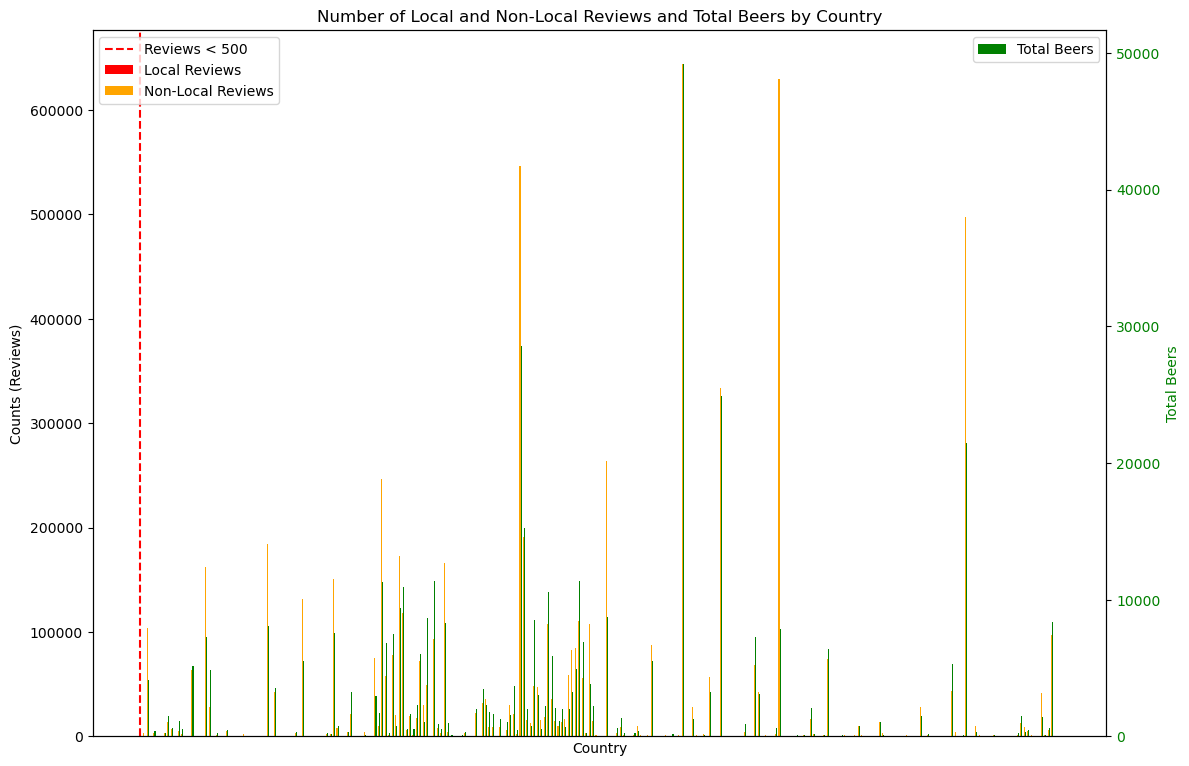

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))

bar_width = 0.3
index = range(len(country_data))

# Plot the bars for the 3 different metrics on the primary y-axis
bar1 = ax1.bar(index, country_data['local_reviews'], bar_width, label='Local Reviews', color='red')
bar2 = ax1.bar([i + bar_width for i in index], country_data['non_local_reviews'], bar_width, label='Non-Local Reviews', color='orange')


ax1.set_xlabel('Country')
ax1.set_ylabel('Counts (Reviews)', color='black')
ax1.set_title('Number of Local and Non-Local Reviews and Total Beers by Country')


#Secondary axis (for the total number of beers)
ax2 = ax1.twinx()  # Create a second y-axis
bar3 = ax2.bar([i + 2 * bar_width for i in index], country_data['total_beers'], bar_width, label='Total Beers', color='green')

# Set labels for the secondary axis (right y-axis)
ax2.set_ylabel('Total Beers', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#Arbitrary cut off: where there are less than 500 non local and local reviews
for i in range(len(country_data)):  # Loop through all countries
    if country_data['local_reviews'].iloc[i] < 500 and country_data['non_local_reviews'].iloc[i] < 500:
        line_x = i + bar_width  # Place the line after the first pair of bars where condition is met
        break
if line_x is not None:
    ax1.axvline(x=line_x, color='red', linestyle='--', label='Reviews < 500')

# Now add the legend for the plot elements
ax1.legend(loc='upper left')
# Adjust layout for readability
plt.tight_layout()
ax1.set_xticks([])  # Remove x-ticks

plt.show()
